# Spectroscopy 

#### The purpose of this lab is to record, plot, and analyze the spectra of one of each type of star in the O, B, A, F, G, K, M spectrum of stars and to determine what elements are present in those stars based on their absoprition lines.

#### To begin, we import the necessary packages that will allow us to perform the operations needed. Numpy allows us to use a variety of array features and mathematical operations. Matplotlib will allows us to plot the images we captured. Astropy will allow us to read and work with .FITS type files. Scipy, glob, and os are for convinience is opening our collected data and writing new files.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

from scipy import stats
from scipy.stats import norm

import glob
import os

import numpy.ma as ma

import io

from scipy.optimize import curve_fit

#### Here we define variables that we will need to upload into Python. These variables are assigned a path that will allow Python the search that path looking for the files that we want to work with. The * tells the code to include all file numbers with the same name. 

#### I have named the variables the respective letter of the type of star and corresponding data that the path will obtain.

#### For a couple of the stars, 30 second exposures were taken, and the rest were 60 seconds. So we need to reduce 2 series of dark frames.

#### We will work with flat field images taken as well, and calibrate the data to a known spectra of our mercury arclamp.

In [2]:
O = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_O-star.*.FIT'
B = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_starB.*.FIT'
A = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_A-star.*.FIT'
F = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_F-star.*.FIT'
G = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_G-star.*.FIT'
K = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_K-star.*.FIT'
M = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_M-star.*.FIT'

dark_60 = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_60sec_Darks.*.DARK.FIT'
dark_30 = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_30sec_Darks.*.DARK.FIT'
flat = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/lab_2_flats.*.FIT'
merc_lamp = r'/Users/adamfletcher/Desktop/AST_443.nosync/Spectra Lab/Lab 2 Spectra/ \
lab_2_MercLampSpectrum.00000001.FIT'

#### The master() function will create our master dark images with reduced noise.

In [3]:
def master(a, title):
    # a: file path of data you want read into the array
    # title: what you will title the resulting image of the noise 
    # reduced median image
    
    b = []
    # b: the new array where uploaded FITS images will be stored 
    # in succession
    
    for name in glob.glob(a):
        # Loop through the images and open each one, save the 2D 
        # data that is the
        # image as an array, and then append that array to the 
        # b array.
        hdulist = fits.open(name)
        data = hdulist[0].data
        
        # Uncomment below code to see each image in its raw imshow 
        # form 
        #plt.imshow(data, vmax = 8500)
        #plt.colorbar()
        #plt.show()
        b.append(data)
        
        # Calculate the mean of the image and the 
        # standard deviation.
        # This will be used for determining colorbar
        # parameters.
        mean = np.mean(data)
        std = np.std(data)
        
    # Save the new b array as a numpy array
    b_array = np.array(b)

    # take the median of the numpy b array
    master_b = np.median(b_array, axis=0)

    # Plot the resulting median/ noise reduced 2D image with the 
    # title designated 
    # at the time the function was called.
    plt.imshow(master_b, vmin=mean - 1*std, vmax=mean + 1*std)
    plt.title(title)
    plt.ylabel('Row of Pixel Position')
    plt.xlabel('Column of Pixel Position')
    plt.colorbar(label = "Strength of electron transfer per pixel")
    plt.show()
    
    # Give the median array
    return master_b

#### Label and create our dark master images and our master flat fields (for 30 sec and 60 sec) by calling the master() function. Then subtract our darks from our flats. Being that we centered our stars on the middle slit of our specrometer, we want to isolate this section of the image and then take the median of that to form a 1D array of the count values at each pixel position.

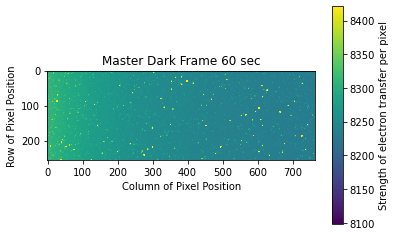

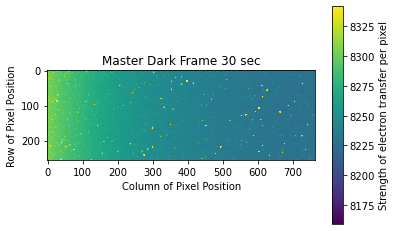

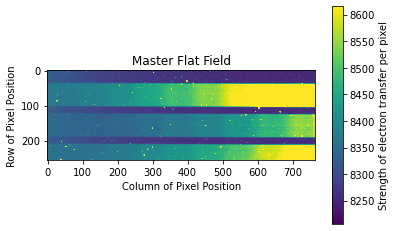

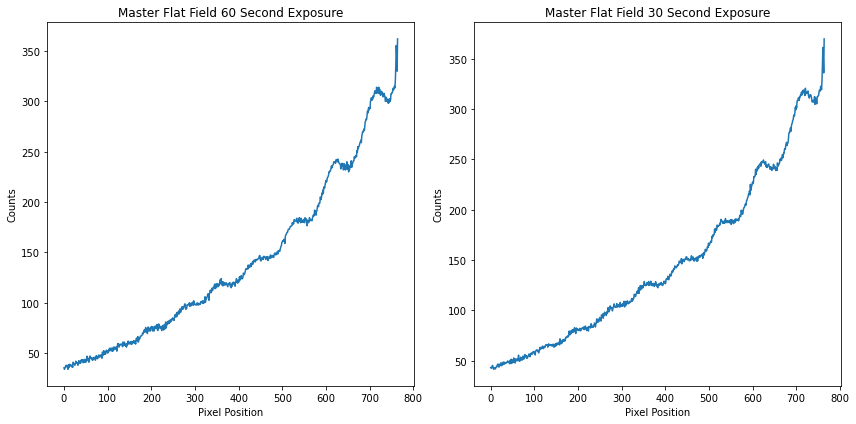

In [4]:
# Create and define master dark frames
dark_master_60 = master(dark_60, 'Master Dark Frame 60 sec')
dark_master_30 = master(dark_30, 'Master Dark Frame 30 sec')

# Create and define master flat field
flat_master = master(flat, 'Master Flat Field') 

# Subtract darks from the flats
flats_60 = flat_master - dark_master_60
flats_30 = flat_master - dark_master_30

# Create a new array of the middle slit and take the median 
# of each column of pixels
slice_flats_60 = np.median(flats_60[120:194], axis = 0)
slice_flats_30 = np.median(flats_30[120:194], axis = 0)

# Define our range of x-values/ pixel position. We know to be 765
x = np.linspace(0,765,765)

#mean_flat = np.nanmean(slice_flats)

#norm_flat = slice_flats / mean_flat

# Plot the Counts v. Pixel Position for each flat field time
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(slice_flats_60)
plt.title('Master Flat Field 60 Second Exposure')
plt.ylabel('Counts')
plt.xlabel('Pixel Position')

plt.subplot(1, 2, 2)
plt.plot(slice_flats_30)
plt.title('Master Flat Field 30 Second Exposure')
plt.ylabel('Counts')
plt.xlabel('Pixel Position')

plt.tight_layout()
plt.show()

#### polynom() defines a line that is a good fit to the curve of our data above. 

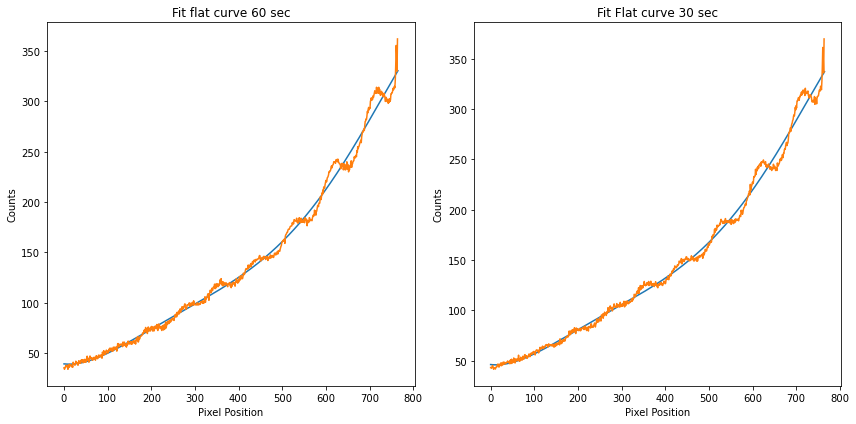

In [5]:
def polynom(x, a):
    # x: the x-axis the function will fit to
    # a: the numpy polyfit array of the 1D array to be fitted
    
    # Calculates and returns an exponential function of values 
    # that will represent the 
    # fit curve at each x position
    at = np.flip(a)
    eq = 0
    for n, an in enumerate(at):
        eq += an * x**n
    return eq

# Defines a to be the numpy polyfit array for 60 second flats, 
# and b to be 30 second flats
a = np.polyfit(x, slice_flats_60, 5, rcond=None, \
               full=False, w=None, cov=False)
b = np.polyfit(x, slice_flats_30, 5, rcond=None, \
               full=False, w=None, cov=False)

# Defines our curve fit lines for 30 and 60 seconds
eq_60 = polynom(x, a)
eq_30 = polynom(x, b)

# Plot our curve fit with our sliced flat field data 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, eq_60)
plt.plot(slice_flats_60)
plt.title('Fit flat curve 60 sec')
plt.ylabel('Counts')
plt.xlabel('Pixel Position')

plt.subplot(1, 2, 2)
plt.plot(x, eq_30)
plt.plot(slice_flats_30)
plt.title('Fit Flat curve 30 sec')
plt.ylabel('Counts')
plt.xlabel('Pixel Position')

plt.tight_layout()
plt.show()

#### There are some "wiggles" in out curves that are noise in our data, so, in order to get rid of those we divide our data by our curved fit and this becomes our Normalized Master Flat Field 

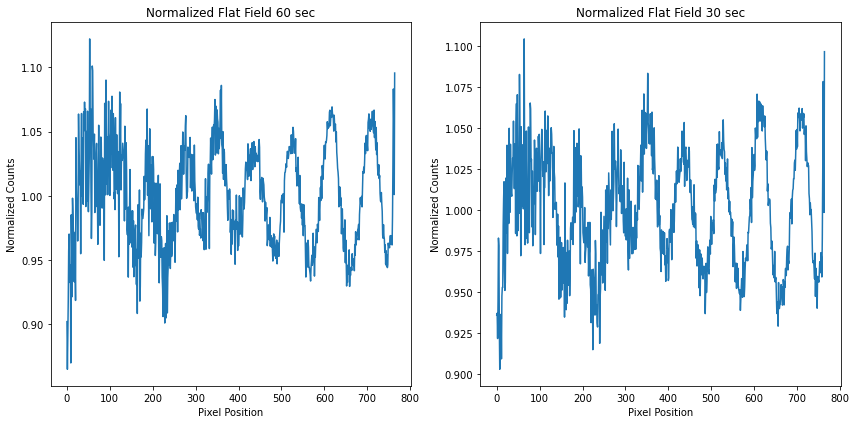

In [6]:
# Divide each flat field of similar length of exposure 
# by the corresponding 
# curve fit. Label it as normalized flat.
normed_flat_60 = slice_flats_60 / eq_60
normed_flat_30 = slice_flats_30 / eq_30

# Plot the Normalized Flat Fields
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(normed_flat_60)
plt.title('Normalized Flat Field 60 sec')
plt.ylabel('Normalized Counts')
plt.xlabel('Pixel Position')

plt.subplot(1, 2, 2)
plt.plot(normed_flat_30)
plt.title('Normalized Flat Field 30 sec')
plt.ylabel('Normalized Counts')
plt.xlabel('Pixel Position')


plt.tight_layout()
plt.show()




#### Now we want to apply this normalization to our calibration spectrum. We take the master() of our mercury lamp and divide it by the normalized flat field. We took 60 second exposure for the Hg lamp so we will used the 60 second normed flat. We want to plot the counts (which are the number of recorded electrons per pixel that are excited by incoming photons and travel across the semi-conductor) against the pixels position.

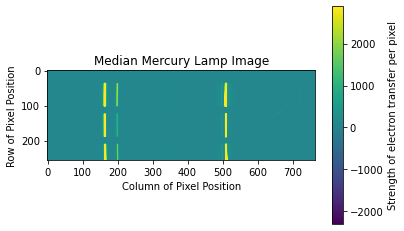

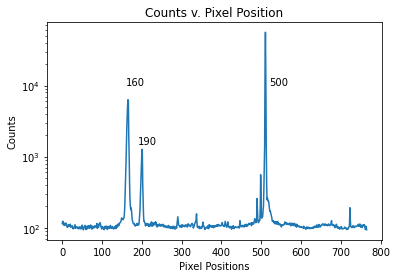

In [7]:
# Take median of Hg lamp data and divide by normalized 
# flat field
merc_master = master(merc_lamp, 'Median Mercury Lamp Image') \
/ normed_flat_60


#x = np.arange(0,765)

# Slice out the middle slit of the spectrum and find its median
slice_merc = np.median(merc_master[120:194], axis = 0)

# Plot the resulting Counts v. Pixel Position
plt.plot(x, slice_merc)
plt.title('Counts v. Pixel Position')
plt.xlabel('Pixel Positions')
plt.ylabel('Counts')
plt.yscale("log")

# Label each peak with the approximate pixel position
plt.text(160, 10000, "160")
plt.text(190, 1500, "190")
plt.text(520, 10000, "500")
plt.show()

#### Pixel Position alone is not very meaningful to us so we want to convert that into wavelength in Angstroms that we can use to understand what wavelengths our spectra are emmitting at. The following cell block will help us to plot a linear regression of the wavelength as a function of pixel position. This will give us our calibrated wavelength spectrum that we can apply to our stars' spectra later.

Sensitivity factor: 0.90 , Min Wavelength: 3898.30, Max Wavelength: 4590.14


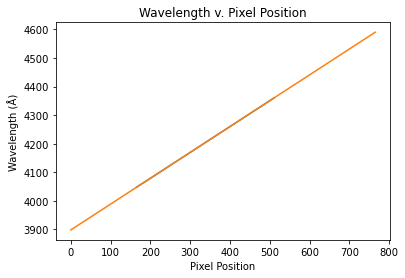

In [8]:
# Returns the indices of the maximum values along the x-axis
# Looking for exact pixel position of each of the peaks 
max_3 = np.argmax(slice_merc[400:750]) + 400
max_1 = np.argmax(slice_merc[100:190]) + 100
max_2 = np.argmax(slice_merc[190:300]) + 190
#print(max_1,max_2,max_3)

# Put the peak values found into a new array 
x_p = [165, 200, 510]
lambda_y = [4047.70,4078.98, 4359.55]
plt.plot(x_p, lambda_y)
plt.title('Wavelength v. Pixel Position')
plt.ylabel('Wavelength (Å)')
plt.xlabel("Pixel Position")

# Find line of best fit
a, b = np.polyfit(x_p, lambda_y, 1)

# Add line of best fit to plot
plt.plot(x, a*x+b)

# New x values that make up the dispersion of wavelength 
# values for our stars
new_x = a*x+b
new_x

# Print the exact min and max wavelength values along 
# with the sensitivity factor.
print(f'Sensitivity factor: {a:.2f} , Min Wavelength: \
{b:.2f}, Max Wavelength: {new_x[764]:.2f}')


#### Now that we have our spread of wavelengths, we can define a function to convert any pixel position into wavelength. That is what the wave() function below does.

In [9]:
# Converts pixel position into wavelength using the 
# linear relationship above
def wave(x):
    # x: pixel position value 
    wave = x*a+b
    return wave

#### spectral_sum() and master() have very similar functions, but the primary difference is that instead of taking the median, of all the x-position columns, spectral_sum() takes the sum of all the columns in order to make a more intense flux per pixel that we can analyze in our data.

In [10]:
def spectral_sum(c, slic, darkframe, normflat):
    # c: path that leads to the data to be summed
    # slic: the slice of the images that comprised the 
    # middle slit of the image
    # darkframe: corresponding dark frame to exp time
    # norm flat: corresponding namalized flat field to 
    # exp time
    
    # d, e: new arrays to store read in data
    d = []
    e = []
    
    # As before, loops through the path, locates the 
    # files, opens them 
    # and saves the data as a 2D array and appends to 
    # the blank 'd' array
    for name in glob.glob(c):
        hdulist = fits.open(name)
        data = hdulist[0].data
        d.append(data)
    
    # Make the 'd' array a 3D numpy array
    d_arr = np.array(d)
    
    # Loop over the arrays in the numpy 'd' array and 
    # subtract the dark frame
    # then divide by the normalized flat field. Then 
    # take the sum of every column
    # and append the resulting 2D array to the blank 'e'
    # array.
    for i in range(len(d_arr)):
        d1 = (d_arr[i] - darkframe) / normflat
        d2 = np.sum(d1[slic], axis=0)#136:180
        e.append(d2)
    
    # To obtain the final 1D array that sums over the 
    # columns of each pixel
    # sum over all the 2D arrays in the 'e' array.
    f = np.sum(e, axis = 0)
    
    return f 

#### raw() is a function that will return the result of the spectral_sum() function, and also fit a curve to that sum function and return the normalized raw spectrum of that star type.

In [11]:
def raw(k, slic, darkframe, normflat): 
    # These parameters are the same as for spectral_sum().
    
    # j: returns the numpy polyfit of the x range and 
    # spectral_sum().
    # eq2: returns the polynom function after passing 
    # the polyfit curve into it.
    j = np.polyfit(x, spectral_sum(k, slic, darkframe, \
        normflat), 5, rcond=None, full=False, w=None, cov=False)
    eq2 = polynom(x, j)
    
    # raw: return the spectral_sum
    # spec: return the normalized raw spectrum
    raw = spectral_sum(k, slic, darkframe, normflat)
    spec = raw / eq2 
    x_wavelength = 3900 + np.arange(765)
    
    #plt.plot(spec)#x_wavelength, spec)
    
    # Plot the Counts v. Pixel Position of the star type and 
    # the Counts v. Wavelength in Angstroms of the normalized 
    # spectrum
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1) 
    plt.plot(spectral_sum(k, slic, darkframe, normflat), \
             label = 'Extracted Spectra')
    plt.plot(x,eq2, label = 'Fit Polynomial')
    plt.title('Counts V. Pixel Position')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.xlabel('Pixel Position')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(new_x, spec)
    plt.ylabel('Normalized Count Value')
    plt.xlabel(r'Wavelength $\AA$')
    plt.title(f'Normalized Spectrum')
    
    plt.tight_layout()
    plt.show
    
    return raw, spec

#### The raw spectrum plots that we will see have deep absorption lines which are the result of certain wavelengths that the star absorbs instead of emmitting. In order to accurately plot a fitted curve to our spectra that does not over compensate for these deep troughs in the graph, we need to mask those areas from being included in the curve fit function.

#### polynomial() will allow us to easily fit a new curve fit to our full spectrum

#### mask() is a large function that is going to handle a large task. mask() will ignore the areas of deep dips and then fit the curve to the plot. Then, it will take the input segments of those x positions of the absorption areas and fit a Gaussian curve to each of them. The area of this fitted Gaussian will be an indication of the "line strength" of that region which will be plotted later for each star spectral type. The function will return the area of each of the 3 dips that are associated with each spectrum as well as the 1D array of the spectrum for use later.

In [12]:
# Define a 3rd-degree polynomial function
def polynomial(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

    # x: x-range
    # a, b, c, d: coefficients found and assigned from calling 
    # the 'curve_fit' object


# Mask out the absorption lines for accurate fit
# Measure the Gaussian area of the Abs lines to determine 
# line strength
def mask(m1, m2, m3, m4, m5, m6, raw, a1, a2, a3, a4, a5, \
         a6, c1, c2, c3):
    # m's: regions to be masked, i.e. from m1-m2, m3-m4, etc.
    # raw: returned 'raw' array from raw() function
    # a's: regions of absorption
    # c's: y-intercept for each Gaussian function (initially 
    # determined by printing
    # those values after plotting the spectrum, but just added 
    # here for organizational
    # and neatness purposes)
    
    # Mask out regions with strong absorption lines.
    # Define a mask where 'True' values indicate regions to be 
    # kept and 'False' values 
    # indicate regions to be masked.
    mask = np.ones_like(raw, dtype=bool)
    
    # Adjusting the mask based on the visible absorption lines
    # from the provided graph
    mask[m1:m2] = False  # Absorption region 
    mask[m3:m4] = False  # Absorption region 
    mask[m5:m6] = False  # Absorption region  

    # Fit the polynomial using only the masked regions
    x = np.arange(len(raw))
    popt, _ = curve_fit(polynomial, x[mask], raw[mask])
    fit_spectrum = polynomial(x, *popt)

    # Plot new spectrum with masked regions. Intensity against 
    # the Pixel Position
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(raw, label='Extracted Spectrum')
    plt.plot(fit_spectrum, label='Fitted Polynomial', \
             linestyle='--')
    plt.title('Masked Spectrum and Fitted Polynomial')
    plt.ylabel('Relative Intensity/Flux')
    plt.xlabel('Pixel Position')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Assuming absorption_regions is the list of start and 
    # end indices of the absorption features
    absorption_regions = [(a1, a2), (a3, a4), (a5, a6)]

    # Loop over the absorption regions to plot each section
    for start, end in absorption_regions:
        # Extract the section of the spectrum
        x_section = np.arange(start, end)
        # Extract the values of the intensity/flux 
        y_section = raw[start:end]
        
        ##### KEPT CODE FOR EASE OF FINDING PROPER ABSORPTION 
        # RANGE #####
        # Plot the section
        #plt.figure(figsize=(8, 6))
        #plt.plot(x_section, y_section, label=f"Absorption 
        # Region {start}-{end}")
        #plt.title(f"Absorption Region {start}-{end}")
        #plt.xlabel('Pixel (corresponding to wavelength)')
        #plt.ylabel('Intensity/Flux')
        #plt.legend()
        #plt.grid(True)
        #plt.tight_layout()
        #plt.show()
    #return fsa
    
    # Define a Gaussian function to fit to the data  
    def gaussian_1(x, a, x0, sigma, c1):      #First absorption 
        # region for the star spectrum.
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c1

    def gaussian_2(x, a, x0, sigma, c2):      #Second absorption 
        # region for the star spectrum.
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c2

    def gaussian_3(x, a, x0, sigma, c3):      #Third absorption 
        # region for the star spectrum.
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c3
    
    # x: range of x-values containing abs areas
    # a: initial guess at the height of the Gaussian
    # x0: x position of the peak of the abs dip
    # sigma: some intial guess for the width of the Gaussian
    # c's: same as what are intially passed into when calling 
    # function
    
    # The next steps are the essential the same, repeated 3 times 
    # for 3 absorption areas.
    # Again, the absorption areas are found by initially plotting 
    # the spectrum first then 
    # identifying the regions from which to take the area of the 
    # Gaussian curve.

    ###################################################################
    ####### 1st Absorption Area #######################################
    
    # Extract the first region 
    x_data_1 = np.arange(a1, a2)
    y_data_1 = raw[a1:a2]

    # Estimate initial parameters for the Gaussian fit
    # Height of the Gaussian
    a_init_1 = -1 * (max(y_data_1) -  min(y_data_1))
    # Position of the peak
    x0_init_1 = x_data_1[np.argmin(y_data_1)]  
    # Initial guess for the width
    sigma_init = 10  


    # Fit the Gaussian function to the data
    popt_1, _ = curve_fit(gaussian_1, x_data_1, y_data_1, \
                          p0=[a_init_1, x0_init_1, sigma_init,c1])

    # Generate y values for the fitted Gaussian
    y_gaussian_1 = gaussian_1(x_data_1, a_init_1, x0_init_1, \
                              sigma_init, c1)
    u_gaussian_1 = gaussian_1(x_data_1, *popt_1)

    # Loop over the absorption regions to plot each section
    start_1, end_1 = absorption_regions[0]
    
     # Extract the section of the spectrum
    x_section_1 = np.arange(start_1, end_1)
    y_section_1 = raw[start_1:end_1]

    # Plot the Gaussian curve fit
    plt.figure(figsize=(8, 6))
    plt.plot(x_section_1, y_section_1, label=f"Absorption Region \
    {start_1}-{end_1}")
    plt.title(f"Absorption Region {start_1}-{end_1}")
    plt.xlabel('Pixel (corresponding to wavelength)')
    plt.plot(x_data_1, y_gaussian_1, label = 'fit')
    plt.plot(x_data_1, u_gaussian_1, label = 'curve_fit')
    plt.ylabel('Relative Intensity/Flux (counts)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Area under the Gaussian taken from known integral result 
    # calculated here
    area_A_1 = np.sqrt(2 * np.pi) * popt_1[0] * popt_1[2] 
    print(f'The area of this dip: {area_A_1:.2f}')
    
    line_strength_norm_1 = area_A_1 / c1
    
    ###################################################################
    ####### 2nd Absorption Area #######################################
    
    # Extract the second region
    x_data_2 = np.arange(a3, a4)
    y_data_2 = raw[a3:a4]

    # Estimate initial parameters for the Gaussian fit
    # height of the Gaussian
    a_init_2 = -1 * (max(y_data_2) -  min(y_data_2))   
    # position of the peak
    x0_init_2 = x_data_2[np.argmin(y_data_2)]   
    # some initial guess for the width
    sigma_init = 10  


    # Fit the Gaussian function to the data
    popt_2, _ = curve_fit(gaussian_2, x_data_2, y_data_2, \
                          p0=[a_init_2, x0_init_2, sigma_init,c2])

    # Generate y values for the fitted Gaussian
    y_gaussian_2 = gaussian_2(x_data_2, a_init_2, x0_init_2, \
                              sigma_init, c2)
    u_gaussian_2 = gaussian_2(x_data_2, *popt_2)


    # Loop over the absorption regions to plot each section
    
    start_2, end_2 = absorption_regions[1]
     # Extract the section of the spectrum
    x_section_2 = np.arange(start_2, end_2)
    y_section_2 = raw[start_2:end_2]

    # Plot the Gaussian curve fit
    plt.figure(figsize=(8, 6))
    plt.plot(x_section_2, y_section_2, label=f"Absorption Region \
    {start_2}-{end_2}")
    plt.title(f"Absorption Region {start_2}-{end_2}")
    plt.xlabel('Pixel (corresponding to wavelength)')
    plt.plot(x_data_2, y_gaussian_2, label = 'fit')
    plt.plot(x_data_2, u_gaussian_2, label = 'curve_fit')
    plt.ylabel('Relative Intensity/Flux (counts)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    area_A_2 = np.sqrt(2 * np.pi) * popt_2[0] * popt_2[2] 
    print(f'The area of this dip: {area_A_2:.2f}')
    
    line_strength_norm_2 = area_A_2 / c2
    
    ###################################################################
    ####### 3rd Absorption Area #######################################
    
    # Extract the third region
    x_data_3 = np.arange(a5, a6)
    y_data_3 = raw[a5:a6]

    # Estimate initial parameters for the Gaussian fit
    # height of the Gaussian
    a_init_3 = -1 * (max(y_data_3) -  min(y_data_3))   
    # position of the peak
    x0_init_3 = x_data_3[np.argmin(y_data_3)]   
    # some initial guess for the width
    sigma_init = 10  


    # Fit the Gaussian function to the data
    popt_3, _ = curve_fit(gaussian_3, x_data_3, y_data_3, \
                          p0=[a_init_3, x0_init_3, sigma_init,c3])

    # Generate y values for the fitted Gaussian
    y_gaussian_3 = gaussian_3(x_data_3, a_init_3, \
                              x0_init_3, sigma_init, c3)
    u_gaussian_3 = gaussian_3(x_data_3, *popt_3)


    # Loop over the absorption regions to plot each section
    
    start_3, end_3 = absorption_regions[2]
     # Extract the section of the spectrum
    x_section_3 = np.arange(start_3, end_3)
    y_section_3 = raw[start_3:end_3]

    # Plot the Gaussian curve fit
    plt.figure(figsize=(8, 6))
    plt.plot(x_section_3, y_section_3, label=f"Absorption Region \
    {start_3}-{end_3}")
    plt.title(f"Absorption Region {start_3}-{end_3}")
    plt.xlabel('Pixel (corresponding to wavelength)')
    plt.plot(x_data_3, y_gaussian_3, label = 'fit')
    plt.plot(x_data_3, u_gaussian_3, label = 'curve_fit')
    plt.ylabel('Relative Intensity/Flux (counts)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    area_A_3 = np.sqrt(2 * np.pi) * popt_3[0] * popt_3[2] 
    print(f'The area of this dip: {area_A_3:.2f}')
    
    line_strength_norm_3 = area_A_3 / c3
    
    return area_A_1, area_A_2, area_A_3, fit_spectrum, \
line_strength_norm_1, line_strength_norm_2, line_strength_norm_3

#### The last thing to do before we can start analyzing our data, is to cut out only that part of the image that we need to work with for each star. To do this I opened DS9 and by hand found the average row ranges for each series of data for each type of star. Below we define the slice of each image to be analyzed and that will be passed into our raw() function.

In [13]:
Ostar_slice = slice(143,182)
Bstar_slice = slice(145,160)
Astar_slice = slice(110,176)
Fstar_slice = slice(120,182)
Gstar_slice = slice(130,162)
Kstar_slice = slice(147,194)
Mstar_slice = slice(140,175)

#### Now we can begin working with the actual data collected. When we collected our data we identified 7 target stars from which to record a spectra, each star representing one of the primary 7 spectral types. We chose (in spectral order): 10 Lacertae, 9 Pegasi, Vega, Polaris, Alpheratz, Sigma Draconis, and Mirach. Once we located the star we placed it in the middle slit of our spectrometer and took a series of exposures for 30 seconds keeping the star centered in the slit for the duration. 10 Lacertae nad 9 Pegasi were relatively faint so we took 60 second exposures for those two.

#### The first thing we will do with each spectra is to use our raw() function to plot the raw spectrum as a function of pixel position and fit a line to that function and also to plot the normalized spectrum as a function of the wavelength dispersion.

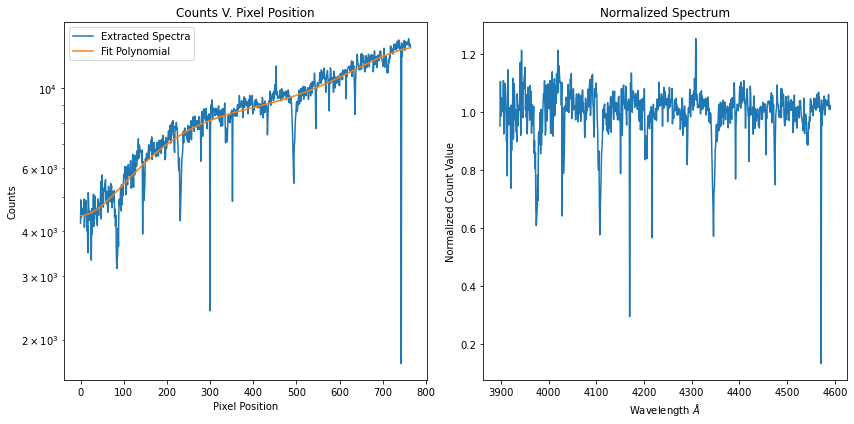

In [14]:
# We want to save our spectral sum array and the normalized raw spectrum
# for later use of plotting the total fluxes vs. wavelength.
Ostar_cal, spec_O = raw(O, Ostar_slice, dark_master_60, normed_flat_60)

#### Next we will us the mask() function to obtain the areas under each absorption curve. The mask regions and absorption regions can be found relatively simply by just looking at the Counts v. Pixel Position above and then passed into our mask() function. For fine tuning the exact parameters we can uncomment the block of code within the function that plots a zoomed in version of each absorption area and from that we can choose more exact boundary points. This was done ahead of time for our stars so all of the parameters shown have been optimized. 

#### The exact 'c' values were obtained by printing the y-intercept values of the plotted absorption areas.

#### We change the y-axis to be in terms of Intensity/Flux, since the count value is simply a representation of just that. This will be normalized later so the units are irrelevant.

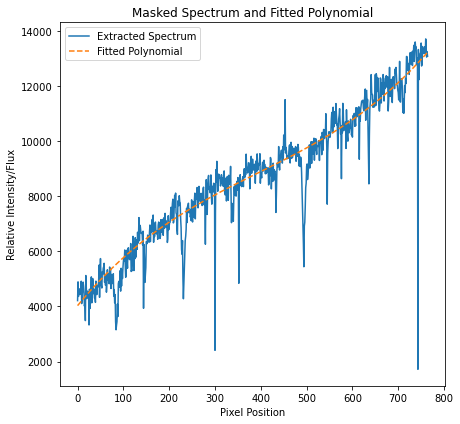

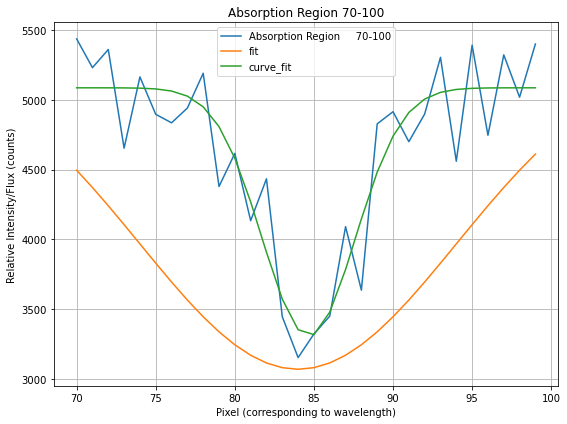

The area of this dip: -13124.40


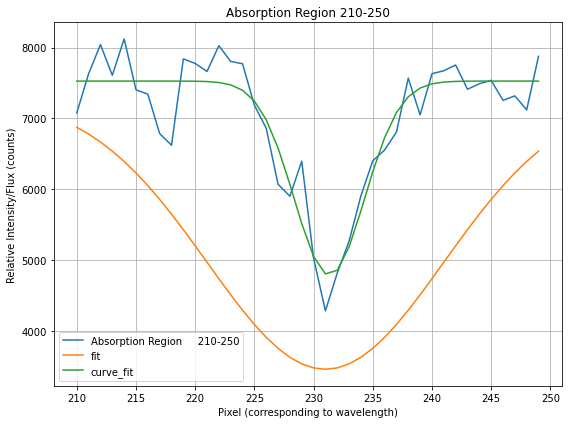

The area of this dip: 20406.20


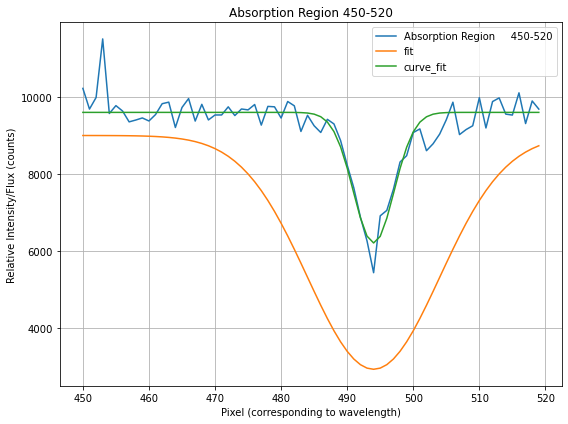

The area of this dip: -26106.25


In [15]:
# O star Absorption Line strength

O_1, O_2, O_3, fit_spectrum_O, LS1_O, LS2_O, LS3_O = \
mask(70, 100, 210, 250, 450, 500, Ostar_cal, 70, 100, 210,\
     250, 450, 520, 5351.63, 7298.32, 9010.23) 

#### In each of our absorption curves we see an orange fit and a green fit to the dip. The orange line is the initial guess at the curve and the green line is the code fitting a better curve to our dips. The area shown is calculated from the green curve fit line.

#### As stated before the wavelength is where we really learn about the composition of this star, so we will use the wave() function toconvert these abs regions into wavelengths. Then we can compare these calculated wavelengths to known wavelengths of elements that absorb at that range. Thus, we will determine the elemental composition of each of our stars.

In [16]:
# Convert the pixel position to wavelength
pix_wav_o1 = wave(84)
pix_wav_o2 = wave(231)
pix_wav_o3 = wave(495)

#### Thanks to our functions we will simply execute these same 3 lines of code for each star. All data relating to a star will have its spectral class in the name.

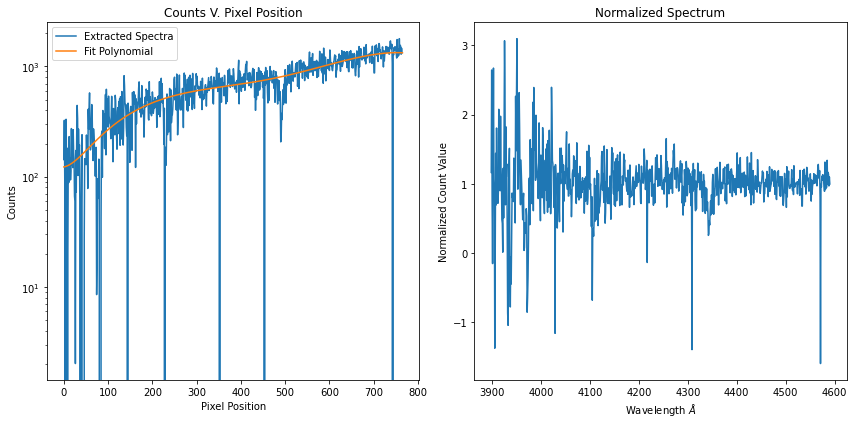

In [17]:
Bstar_cal, spec_B = raw(B, Bstar_slice, dark_master_60, normed_flat_60)

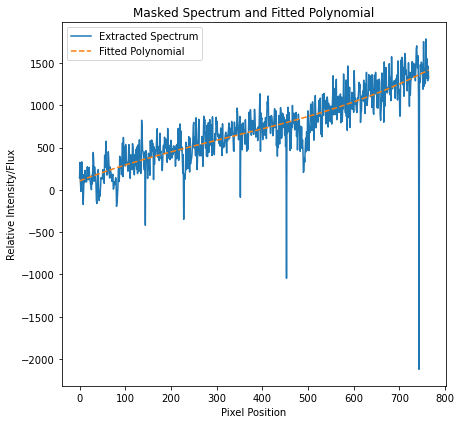

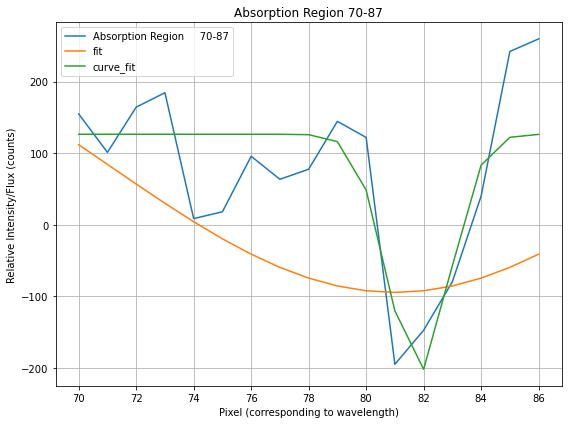

The area of this dip: -894.88


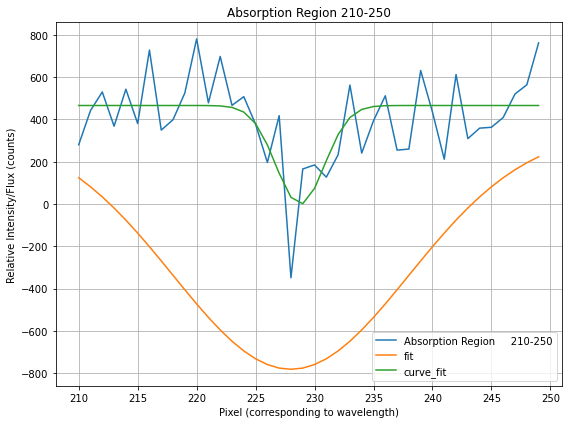

The area of this dip: -2404.54


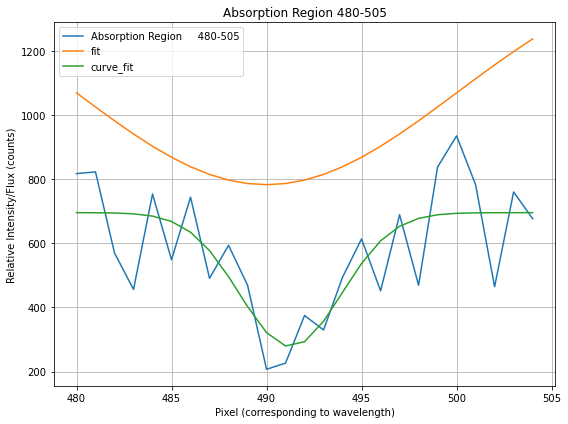

The area of this dip: -2811.55


In [18]:
# B star Absorption Line strength

B_1, B_2, B_3, fit_spectrum_B, LS1_B, LS2_B, LS3_B  = \
mask(20, 60, 77, 81, 488, 500, Bstar_cal, 70, 87, 210, \
     250, 480, 505, 360, 347.98, 1510.99) 

In [19]:
# Convert the pixel position to wavelength
pix_wav_b1 = wave(81)
pix_wav_b2 = wave(227)
pix_wav_b3 = wave(490)

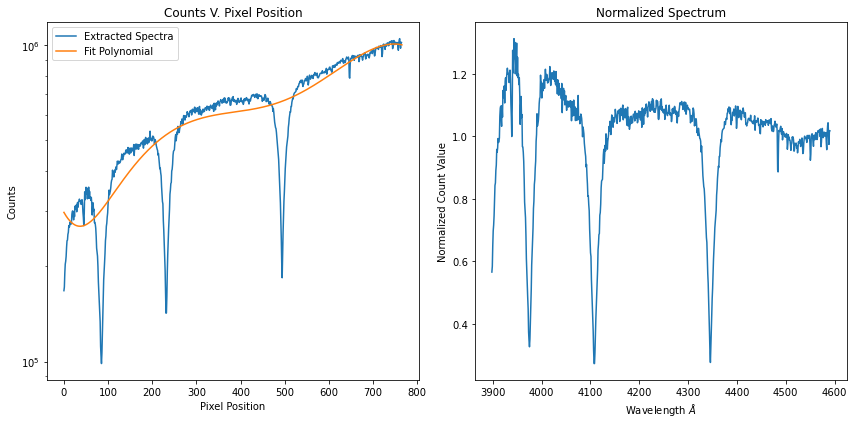

In [20]:
Astar_cal, spec_A = raw(A, Astar_slice, dark_master_30, normed_flat_30)

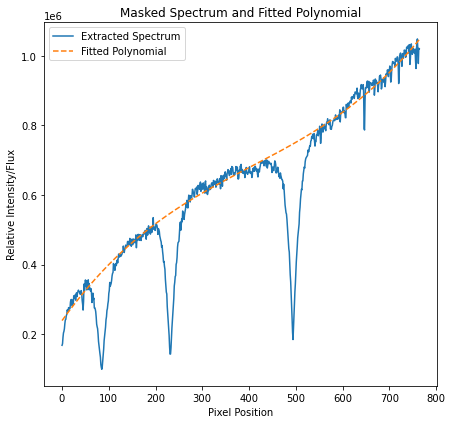

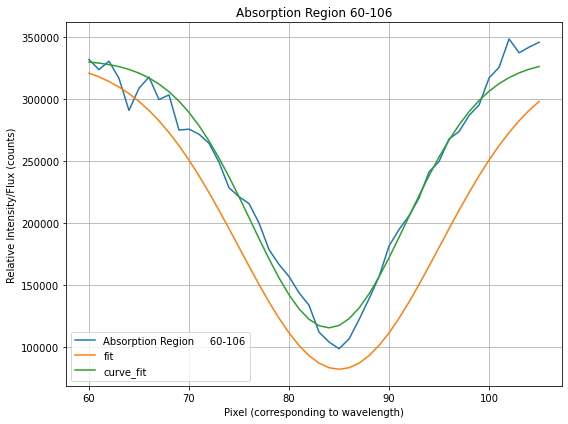

The area of this dip: -4193411.91


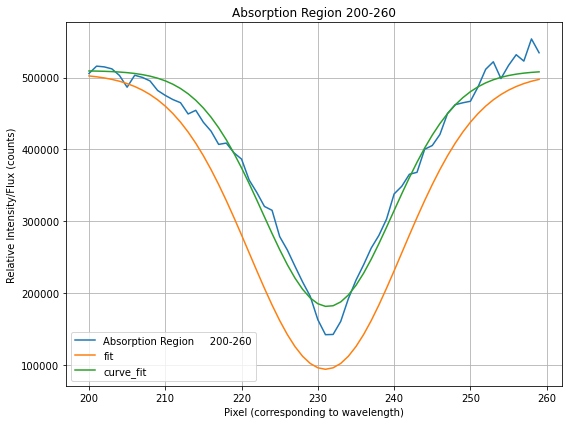

The area of this dip: -6991130.09


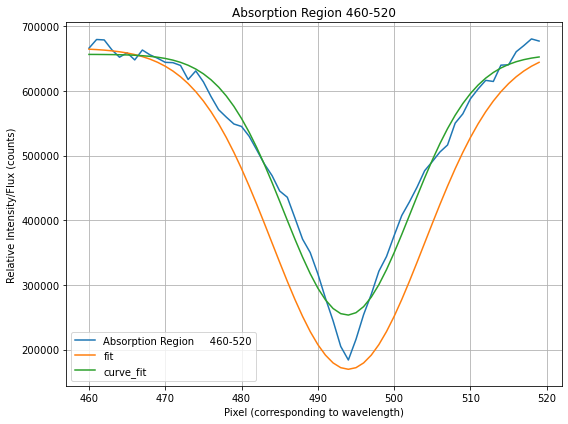

The area of this dip: -8373054.68


In [21]:
# A star Absorption Line Strength

A_1, A_2, A_3, fit_spectrum_A, LS1_A, LS2_A, LS3_A = \
mask(50, 130, 200, 300, 450, 550, Astar_cal, 60, 106, \
     200, 260, 460, 520, 331738.45, 505712.12, 666218.29)


In [22]:
# Convert the pixel position to wavelength

pix_wav_a1 = wave(85)
pix_wav_a2 = wave(231)
pix_wav_a3 = wave(494)

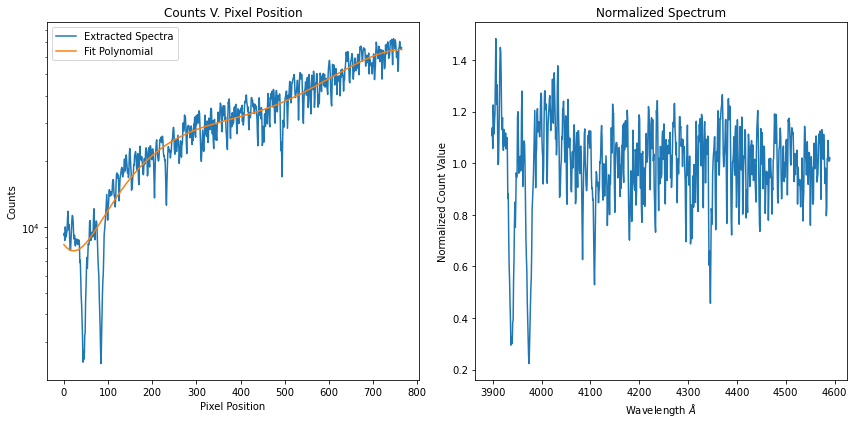

In [23]:
Fstar_cal, spec_F = raw(F, Fstar_slice, dark_master_30, normed_flat_30)

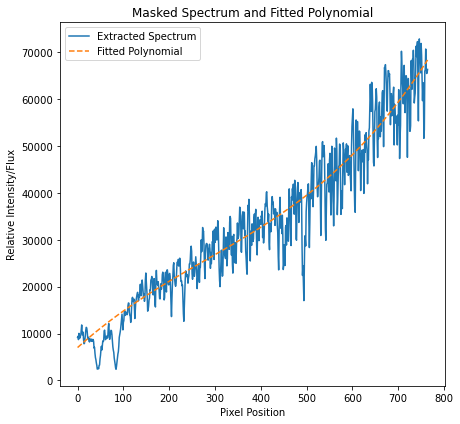

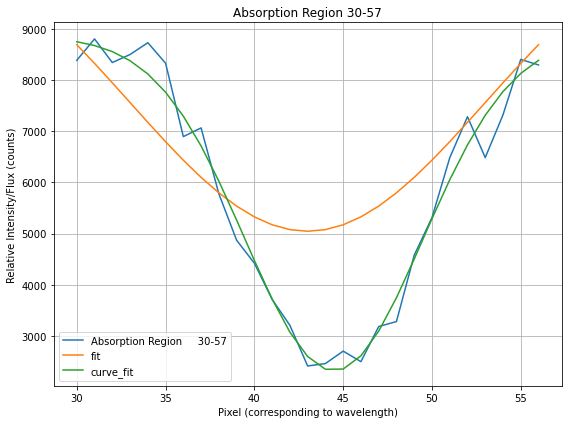

The area of this dip: -81886.21


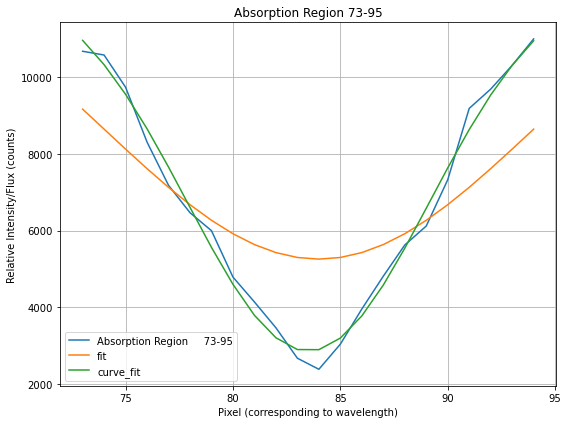

The area of this dip: -138101.74


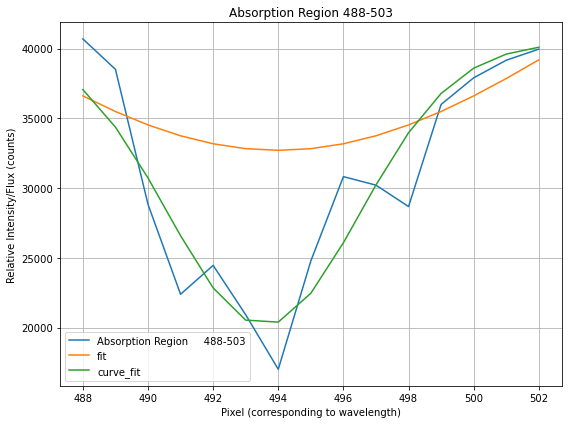

The area of this dip: 148938.85


In [24]:
# F star Absorption Line strength

F_1, F_2, F_3, fit_spectrum_F, LS1_F, LS2_F, LS3_F = \
mask(33, 55, 75, 95, 486, 503, Fstar_cal, 30, 57, 73, \
     95, 488, 503, 11433.60, 13881.64, 56383.18)

In [25]:
# Convert the pixel position to wavelength

pix_wav_f1 = wave(45)
pix_wav_f2 = wave(84)
pix_wav_f3 = wave(494)

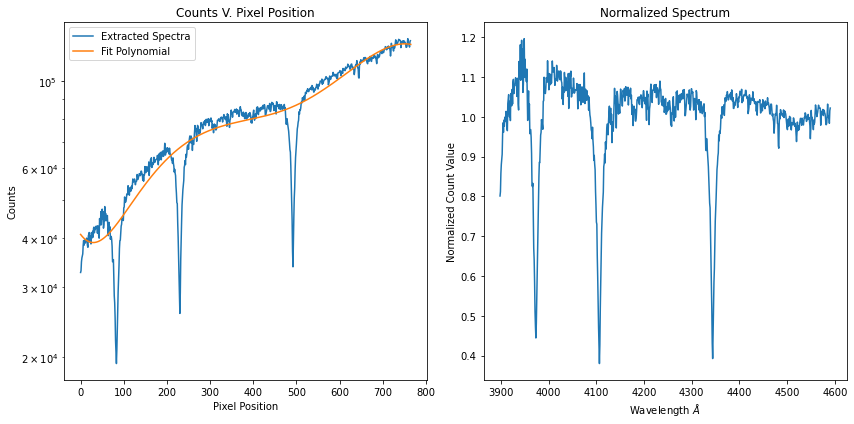

In [26]:
Gstar_cal, spec_G = raw(G, Gstar_slice, dark_master_30, normed_flat_30)

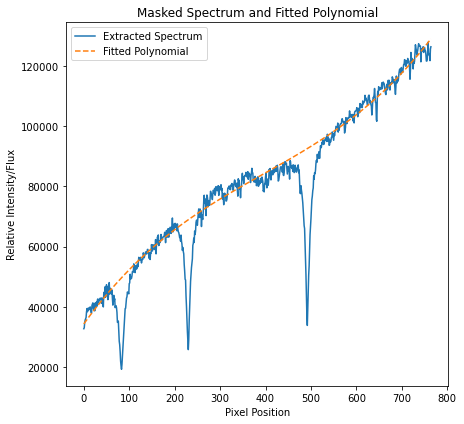

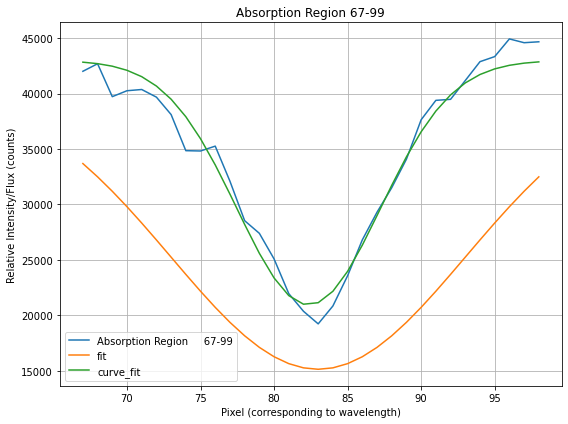

The area of this dip: -269123.07


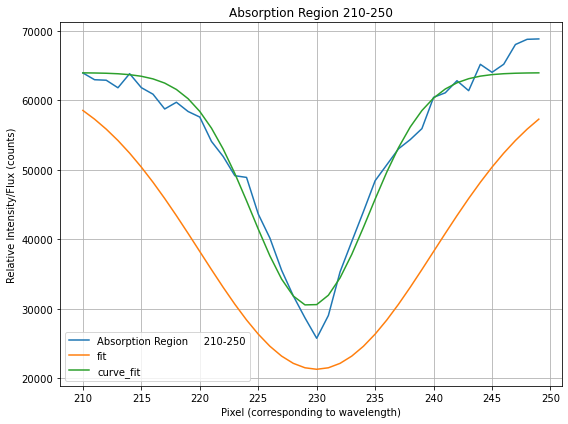

The area of this dip: -420056.19


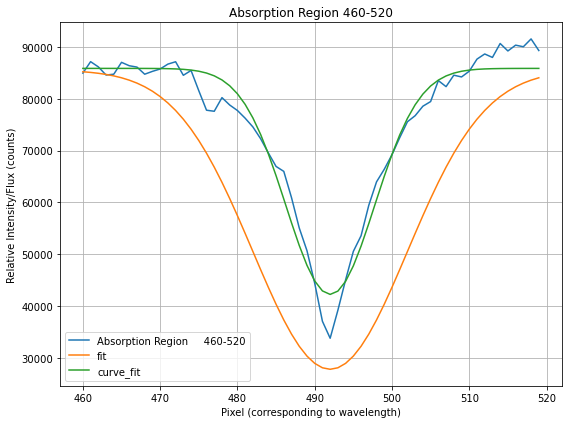

The area of this dip: -628013.26


In [27]:
# G star Absorption Line strength

G_1, G_2, G_3, fit_spectrum_G, LS1_G, LS2_G, LS3_G = \
mask(70, 95, 210, 250, 460, 520, Gstar_cal, 67, 99, 210,\
     250, 460, 520, 40828.01, 64361.68, 85561.65)

In [28]:
# Convert the pixel position to wavelength

pix_wav_g1 = wave(83)
pix_wav_g2 = wave(230)
pix_wav_g3 = wave(492)

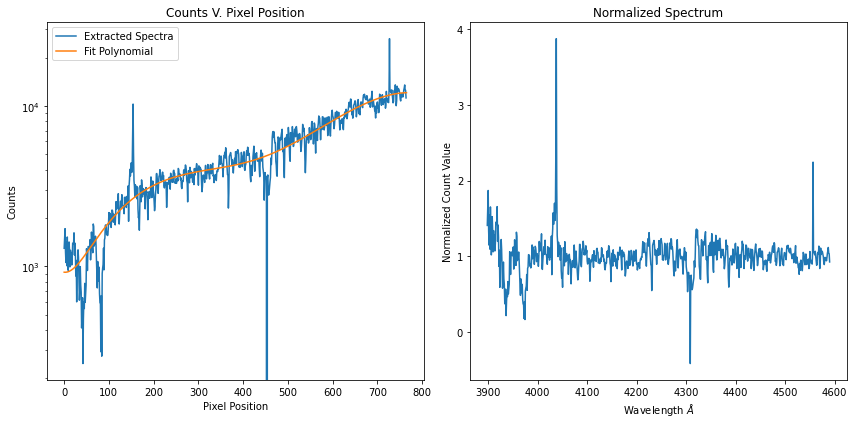

In [29]:
Kstar_cal, spec_K = raw(K, Kstar_slice, dark_master_30, normed_flat_30)

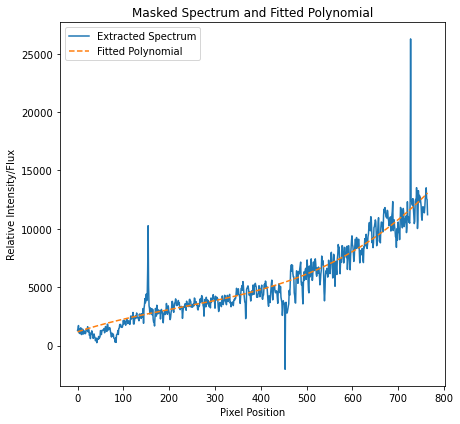

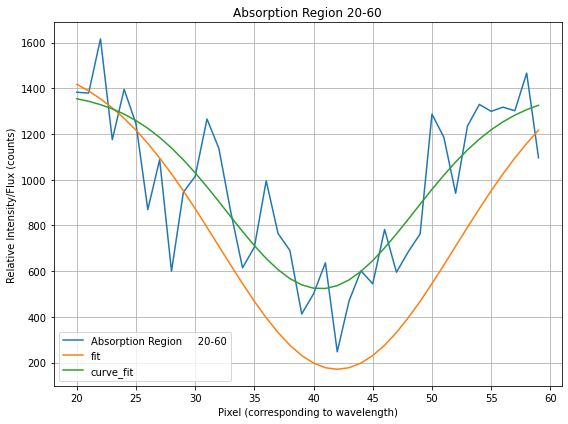

The area of this dip: -17141.52


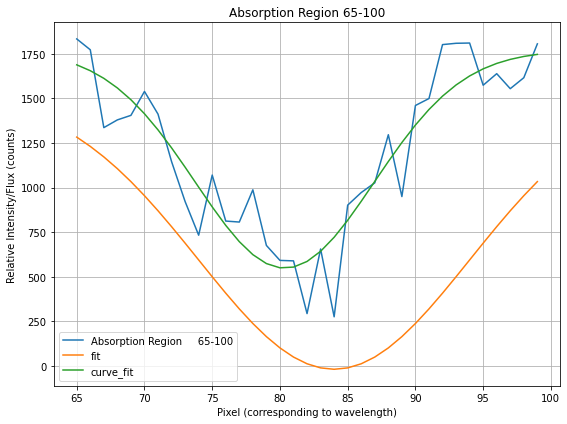

The area of this dip: -20181.79


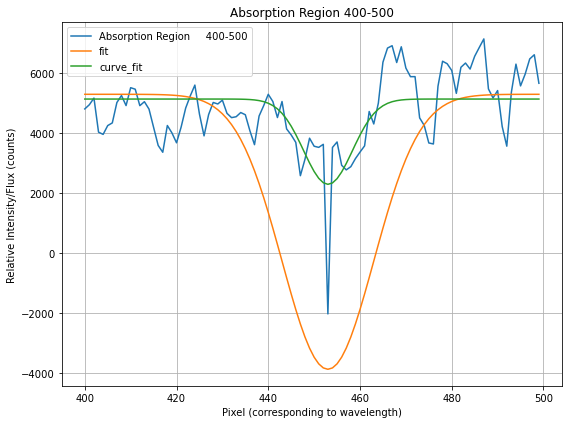

The area of this dip: -37874.56


In [30]:
# K star Absorption Line strength

K_1, K_2, K_3, fit_spectrum_K, LS1_K, LS2_K, LS3_K = \
mask(20, 60, 70, 100, 400, 500, Kstar_cal, 20, 60, 65, \
     100, 400, 500, 1539.63, 1539.83, 5302.05)

In [31]:
# Convert the pixel position to wavelength

pix_wav_k1 = wave(42)
pix_wav_k2 = wave(83)
pix_wav_k3 = wave(451)

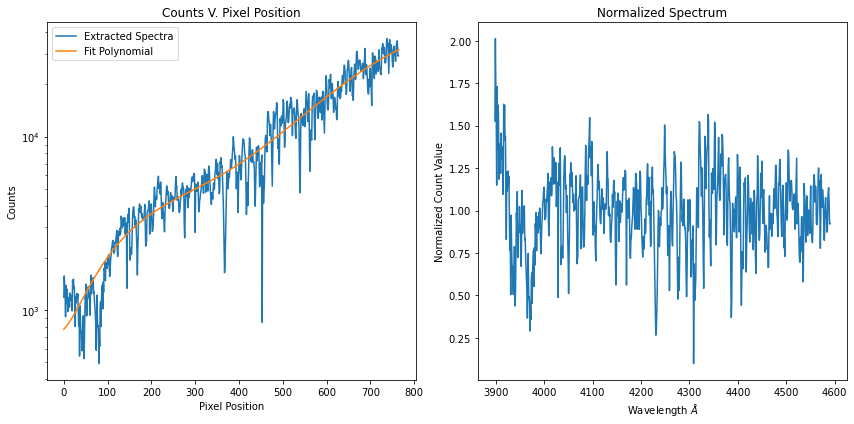

In [32]:
Mstar_cal, spec_M = raw(M, Mstar_slice, dark_master_30, normed_flat_30)

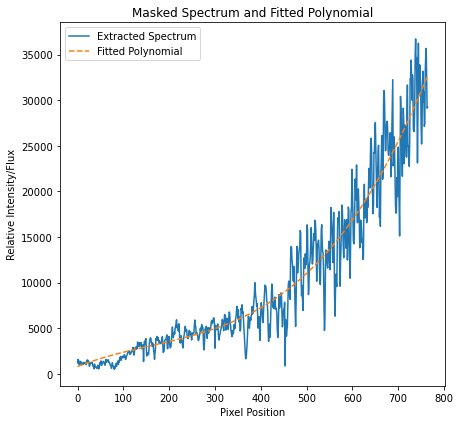

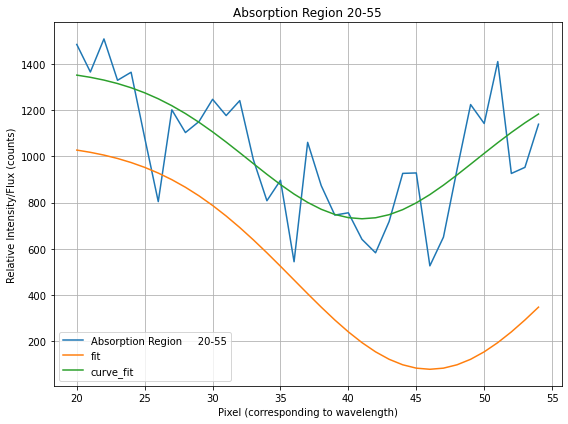

The area of this dip: -13663.31


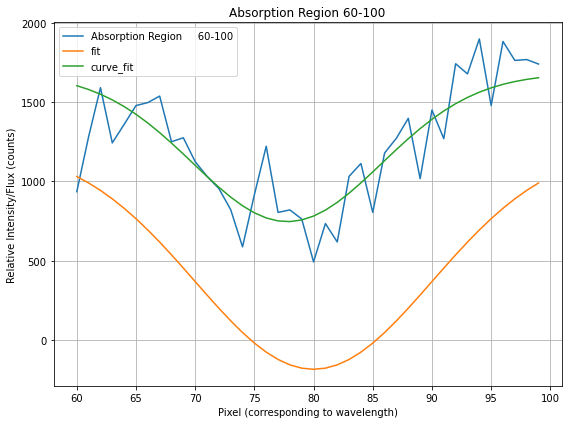

The area of this dip: -18680.16


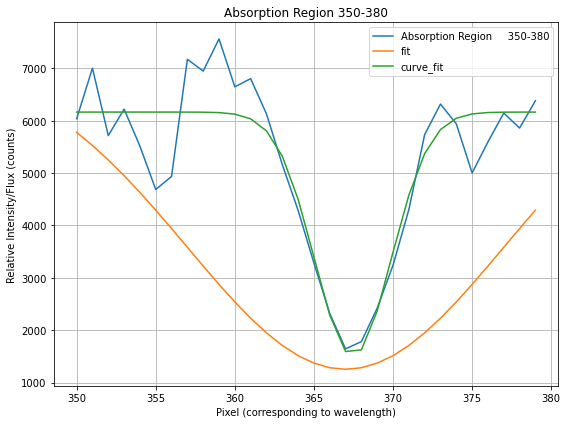

The area of this dip: -28150.21


In [33]:
# M star Absorption Line strength

M_1, M_2, M_3, fit_spectrum_M, LS1_M, LS2_M, LS3_M = \
mask(20, 50, 60, 90, 350, 380, Mstar_cal, 20, 55, 60, \
     100, 350, 380, 1060.57, 1221.83, 7172.59)

In [34]:
# Convert the pixel position to wavelength

pix_wav_m1 = wave(46)
pix_wav_m2 = wave(80)
pix_wav_m3 = wave(367)

#### We now have the wavelengths of our absorption lines to within a margin of uncertainty of a few Angstroms. The next block of code is our analysis of each of those wavelengths compared to the elemental compounds that absorb in that range. From the table we gain great insight into what mostly comprises our target stars.

In [35]:
import prettytable 

from prettytable import PrettyTable 
 

myTable = PrettyTable(["Star Class", "Abs Line #", \
        "Abs Wavelength", "Element", "Ideal Wavelength"]) 
 
# Add rows 
myTable.add_row(["O", "1", f"{pix_wav_o1:.0f}", "H\u03B5", "3970"])
myTable.add_row(["O", "2", f"{pix_wav_o2:.0f}", "H\u0394", "4101"])
myTable.add_row(["O", "3", f"{pix_wav_o3:.0f}", "HeI", "4348"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["B", "1", f"{pix_wav_b1:.0f}", "H\u03B5", "3970"])
myTable.add_row(["B", "2", f"{pix_wav_b2:.0f}", "H\u0394", "4101"])
myTable.add_row(["B", "3", f"{pix_wav_b3:.0f}", "Hg", "4340"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["A", "1", f"{pix_wav_a1:.0f}", "H\u03B5", "3970"])
myTable.add_row(["A", "2", f"{pix_wav_a2:.0f}", "H\u0394", "4101"])
myTable.add_row(["A", "3", f"{pix_wav_a3:.0f}", "HeI", "4348"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["F", "1", f"{pix_wav_f1:.0f}", "Ca II H", "3933"])
myTable.add_row(["F", "2", f"{pix_wav_f2:.0f}", "H\u03B5", "3970"])
myTable.add_row(["F", "3", f"{pix_wav_f3:.0f}", "HeI", "4348"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["G", "1", f"{pix_wav_g1:.0f}", "H\u03B5", "3970"])
myTable.add_row(["G", "2", f"{pix_wav_g2:.0f}", "H\u0394", "4101"])
myTable.add_row(["G", "3", f"{pix_wav_g3:.0f}", "HeI", "4348"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["K", "1", f"{pix_wav_k1:.0f}", "Ca II H", "3933"])
myTable.add_row(["K", "2", f"{pix_wav_k2:.0f}", "H\u03B5", "3970"])
myTable.add_row(["K", "3", f"{pix_wav_k3:.0f}", "CH", "4300"])
myTable.add_row([" ", " ", " ", " ", " "])
myTable.add_row(["M", "1", f"{pix_wav_m1:.0f}", "Ca II H", "3933"])
myTable.add_row(["M", "2", f"{pix_wav_m2:.0f}", "H\u03B5", "3970"])
myTable.add_row(["M", "3", f"{pix_wav_m3:.0f}", "Ca I", "4227"])
 
print(myTable)

+------------+------------+----------------+---------+------------------+
| Star Class | Abs Line # | Abs Wavelength | Element | Ideal Wavelength |
+------------+------------+----------------+---------+------------------+
|     O      |     1      |      3974      |    Hε   |       3970       |
|     O      |     2      |      4107      |    HΔ   |       4101       |
|     O      |     3      |      4346      |   HeI   |       4348       |
|            |            |                |         |                  |
|     B      |     1      |      3972      |    Hε   |       3970       |
|     B      |     2      |      4104      |    HΔ   |       4101       |
|     B      |     3      |      4341      |    Hg   |       4340       |
|            |            |                |         |                  |
|     A      |     1      |      3975      |    Hε   |       3970       |
|     A      |     2      |      4107      |    HΔ   |       4101       |
|     A      |     3      |      4345 

#### We are interested in creating a plot of the line strength of the absorption regions for each spectral class. The areas calculated from the Gaussian curves represent the line strength. The code below will plot a bar graph for each spectral class with 3 points in each bar representing the line strength of each abs region.

In [36]:
# Make an area of all the line strength values 
# (i.e. area of the dip)
# We have to make each value positive since the areas 
# calcualted were 
# inverted Gaussians, they gave negative values. So, 
# here we will
# take the absolute value of each area and save it as a
# new array called
# 'areas'.

areas = np.array([
    np.abs(O_1), np.abs(O_2), np.abs(O_3), 
    np.abs(B_1), np.abs(B_2), np.abs(B_3),
    np.abs(A_1), np.abs(A_2), np.abs(A_3),
    np.abs(F_1), np.abs(F_2), np.abs(F_3),
    np.abs(G_1), np.abs(G_2), np.abs(G_3),
    np.abs(K_1), np.abs(K_2), np.abs(K_3),
    np.abs(M_1), np.abs(M_2), np.abs(M_3)
])

areas

array([1.31244011e+04, 2.04061955e+04, 2.61062455e+04, 8.94875434e+02,
       2.40454398e+03, 2.81154770e+03, 4.19341191e+06, 6.99113009e+06,
       8.37305468e+06, 8.18862115e+04, 1.38101741e+05, 1.48938851e+05,
       2.69123072e+05, 4.20056194e+05, 6.28013255e+05, 1.71415207e+04,
       2.01817939e+04, 3.78745628e+04, 1.36633136e+04, 1.86801602e+04,
       2.81502110e+04])

In [37]:
norm_areas = np.array([
    np.abs(LS1_O), np.abs(LS2_O), np.abs(LS3_O), 
    np.abs(LS1_B), np.abs(LS2_B), np.abs(LS3_B),
    np.abs(LS1_A), np.abs(LS2_A), np.abs(LS3_A),
    np.abs(LS1_F), np.abs(LS2_F), np.abs(LS3_K),
    np.abs(LS1_G), np.abs(LS2_G), np.abs(LS3_G),
    np.abs(LS1_K), np.abs(LS2_K), np.abs(LS3_K),
    np.abs(LS1_M), np.abs(LS2_M), np.abs(LS3_M)
])

norm_areas

array([ 2.45241191,  2.79601271,  2.89740057,  2.48576509,  6.91000626,
        1.86073217, 12.64071715, 13.82432773, 12.56803484,  7.16189227,
        9.94851765,  7.14338092,  6.59162844,  6.52649518,  7.33989183,
       11.13353256, 13.10650782,  7.14338092, 12.88299086, 15.2886737 ,
        3.92469262])

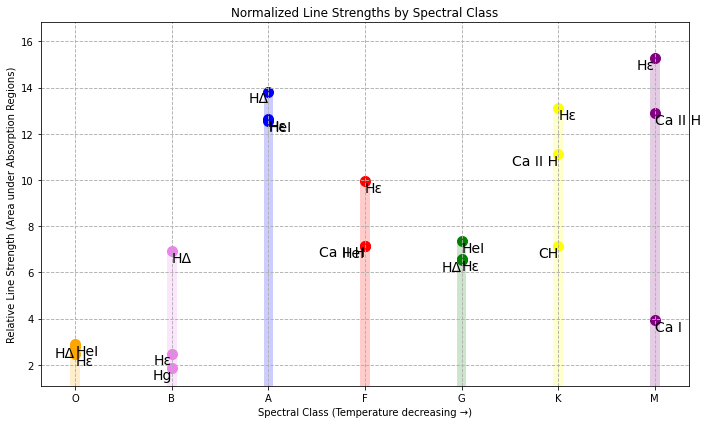

In [38]:
spectral_classes = ['O', 'O', 'O', 'B', 'B', 'B', \
                    'A', 'A', 'A', 'F', 'F', 'F',\
                    'G', 'G', 'G', 'K', 'K', 'K',\
                    'M', 'M', 'M']

# Elements corresponding to each data point
elements = ['H\u03B5', 'H\u0394', 'HeI', 'H\u03B5', \
            'H\u0394', 'Hg', 'H\u03B5', 'H\u0394', \
            'HeI', 'Ca II H', 'H\u03B5', 'HeI',
            'H\u03B5', 'H\u0394', 'HeI', 'Ca II H', \
            'H\u03B5', 'CH', 'Ca II H', 'H\u03B5', \
            'Ca I']

# We will make the height of our line strength bar 
# the height of the 
# maximum peak of our abs areas.
# Since the number of entries in `areas` now matches 
# `spectral_classes`, 
# we'll calculate the max areas accordingly.
max_area_O = max(norm_areas[:3])
max_area_B = max(norm_areas[3:6])
max_area_A = max(norm_areas[6:9])
max_area_F = max(norm_areas[9:12])
max_area_G = max(norm_areas[12:15])
max_area_K = max(norm_areas[15:18])
max_area_M = max(norm_areas[18:21])

plt.figure(figsize=(10, 6))

# Colors for spectral classes
colors = {'O': 'orange','B': 'violet','A': 'blue', 'F': \
    'red', 'G': 'Green', 'K': 'yellow', 'M': 'purple'}

# Scatter plot of all the areas for each spectral class
# Loop through each element in spectral class array and plot each 
# point on a scatter plot with the areas for each spectral class
# and associated element causing the absorption
for i, sclass in enumerate(spectral_classes):
    plt.scatter(sclass, norm_areas[i], color=colors[sclass], s=100)
    # Add a text label with the corresponding element
    ha_direction = 'left' if i % 2 == 0 else 'right'
    plt.text(sclass, norm_areas[i], elements[i], fontsize=14, \
             ha=ha_direction, va='top')


# Adding bars for temperature range of each spectral class to see
# where our star falls in that range.
plt.bar('O', max_area_O, width=0.1, bottom=0, color='orange', alpha=0.2)
plt.bar('B', max_area_B, width=0.1, bottom=0, color='violet', alpha=0.2)
plt.bar('M', max_area_M, width=0.1, bottom=0, color='purple', alpha=0.2)
plt.bar('K', max_area_K, width=0.1, bottom=0, color='yellow', alpha=0.2)
plt.bar('G', max_area_G, width=0.1, bottom=0, color='green', alpha=0.2)
plt.bar('F', max_area_F, width=0.1, bottom=0, color='red', alpha=0.2)
plt.bar('A', max_area_A, width=0.1, bottom=0, color='blue', alpha=0.2)


plt.title("Normalized Line Strengths by Spectral Class")
plt.xlabel("Spectral Class (Temperature decreasing →)")
plt.ylabel("Relative Line Strength (Area under Absorption Regions)")
#plt.yscale('linear')

# Adjusting y-axis limits for visibility of all points
min_area = min(norm_areas)
plt.ylim(min_area - 0.05 * max(norm_areas), max(norm_areas) + \
         (0.1 * max(norm_areas)))

plt.grid(True, which='both', linestyle='--', linewidth=0.9)
plt.tight_layout()
plt.show()


In [39]:
max_area_A

13.824327732252222

#### The following code is used for creating a plot of the Flux vs. Wavelength for the purpose of finding the blackbody curves for different temperature ranges of stars. The purpose of this is to determine what our true calibrated wavelength spectrum is for our observations the night we captured our data.

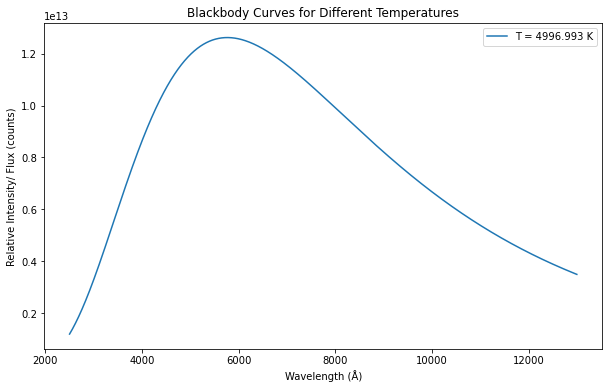

In [57]:
# Constants
h = 6.626e-34  # Planck's constant (Joule second)
c = 3.0e+8    # Speed of light (m/s)
k = 1.38e-23  # Boltzmann constant (Joule per Kelvin)

# Planck's Radiation Law (Blackbody Curve) with correct units
def blackbody_lambda(wavelength, T):
    a = (2.0 * h * c**2) / wavelength**5
    b = (h * c) / (wavelength * k * T)
    intensity = a / (np.exp(b))
    return intensity

# Wavelength in Angstroms
x_wavelength = 3900 + np.arange(765)  
new_xx = np.arange(2500, 13000)
x_wavelength_meters = new_xx * 1e-10  # Convert Angstroms to meters

xwm = 1 / ((x_wavelength_meters)** 5)
# Calculate and plot blackbody spectra for a range of temperatures
plt.figure(figsize=(10, 6))
for T in [4996.993]:#[9602]:
    bb_spectrum = blackbody_lambda(x_wavelength_meters, T)
    plt.plot(new_xx, bb_spectrum, label=f'T = {T} K')

plt.title('Blackbody Curves for Different Temperatures')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Relative Intensity/ Flux (counts)')
plt.legend()
plt.show()

#### Next we need to calculate the sensitivity function (g) for our wavelength calibration.

Length of sensitivity function (g): 765
Length of wavelengths: 765


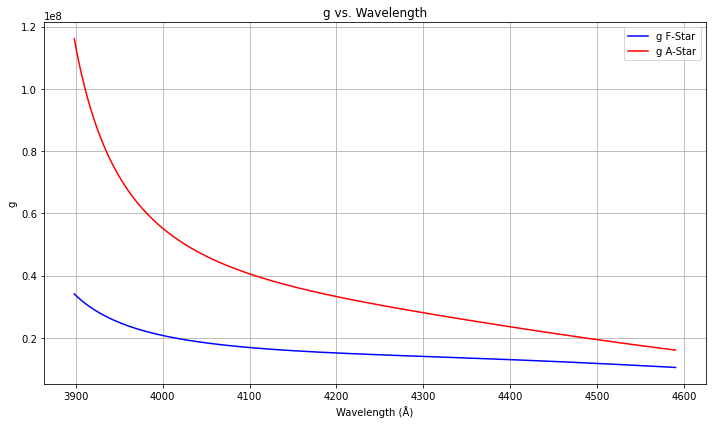

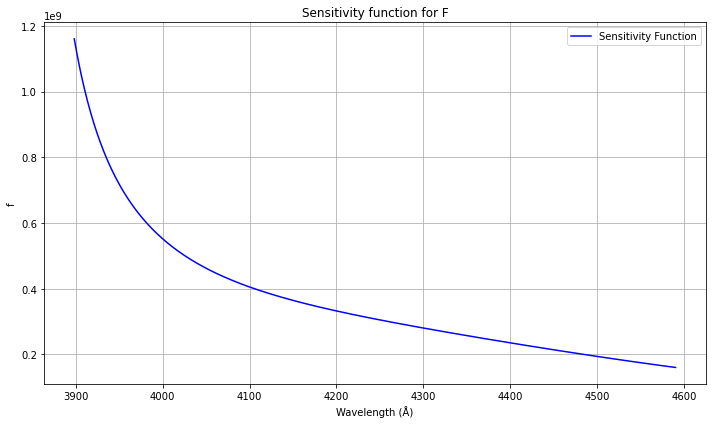

In [41]:
# We are using the A star as our reference star because the spectral lines
# captured from this star are strong, being that Vega is very bright.
g = bb_spectrum/fit_spectrum_A
# Print the length of both arrays
print(f"Length of sensitivity function (g): {len(g)}")
print(f"Length of wavelengths: {len(new_x)}")

# We have a 2D array that we want to flatten to a 1D so we can plot it.
type(g)
g.flatten()
g=g.flatten()

# We will also do the same for our F star
f = bb_spectrum/fit_spectrum_F
f = f.flatten()

# Now we will plot our sensitivity function against the wavelengths 
# for both the F and A stars.
plt.figure(figsize=(10, 6)) 
plt.plot(new_x, g, label='g F-Star', color='blue')
plt.plot(new_x, f/10, label='g A-Star', color='red')
plt.title('g vs. Wavelength')
plt.xlabel('Wavelength (Å)') 
plt.ylabel('g')
plt.grid(True)  
plt.legend()  
plt.tight_layout() 



plt.figure(figsize=(10, 6)) 
plt.plot(new_x, f, label='Sensitivity Function', color='blue')

plt.title('Sensitivity function for F')
plt.xlabel('Wavelength (Å)')  
plt.ylabel('f')
plt.grid(True)  
plt.legend()  
plt.tight_layout() 

#### plot_flux_vs_wavelength() does just what the name entails. We calculate our flux by multiplying the result from the the raw() function by our sensitivity function (g) and plot those against our new wavelength dispersion. We will execute this function for every star.

In [42]:
def plot_flux_vs_wavelength(new_x, star_spectrum, g, star_name):
    # Plots the wavelength vs. flux for a given star's spectrum 
    # adjusted by the sensitivity function.
    # Parameters:
    # new_x: Array of calibrated wavelengths.
    # star_spectrum: Array of the star's spectrum values.
    # g: The sensitivity function.
    # star_name: Name of the star for labeling purposes.
    
    # Calculate the flux
    flux = star_spectrum * g

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(new_x, flux, label=f'g Adjusted Flux for \
    {star_name}', color='blue')

    plt.title(f'Flux v. Wavelength for {star_name}')
    plt.xlabel('Wavelength (Å)') 
    plt.ylabel('Relative Flux (counts)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



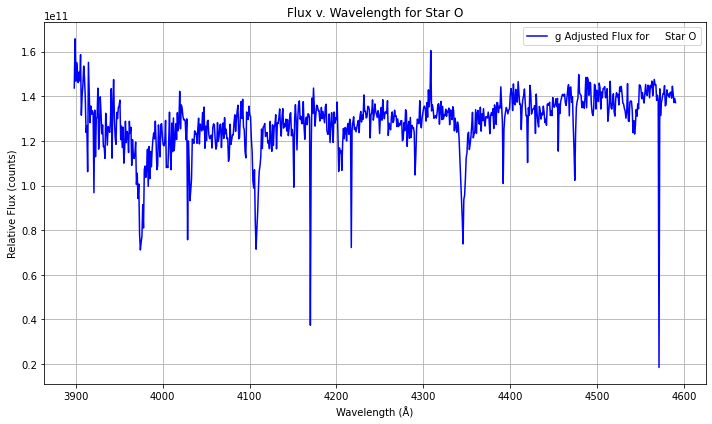

In [43]:
o = plot_flux_vs_wavelength_O = \
plot_flux_vs_wavelength(new_x, Ostar_cal, g, 'Star O')

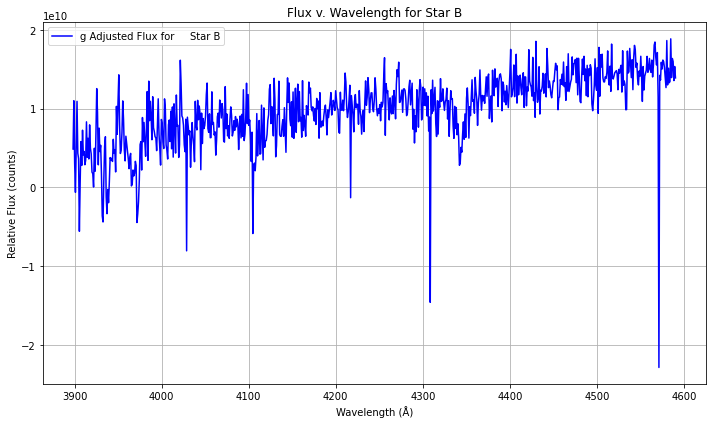

In [44]:
b = plot_flux_vs_wavelength_B = \
plot_flux_vs_wavelength(new_x, Bstar_cal, g, 'Star B')

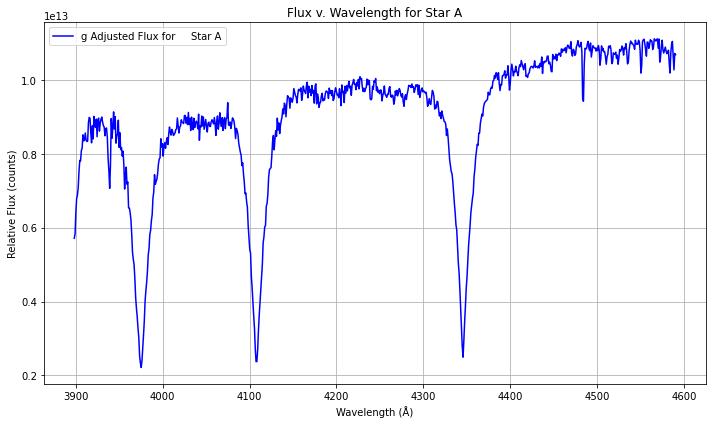

In [45]:
aa = plot_flux_vs_wavelength_A = \
plot_flux_vs_wavelength(new_x, Astar_cal, g, 'Star A')

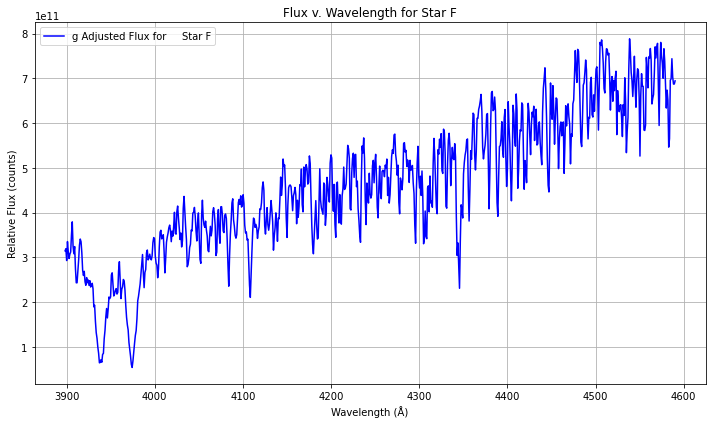

In [46]:
f = plot_flux_vs_wavelength_F = \
plot_flux_vs_wavelength(new_x, Fstar_cal, g, 'Star F')

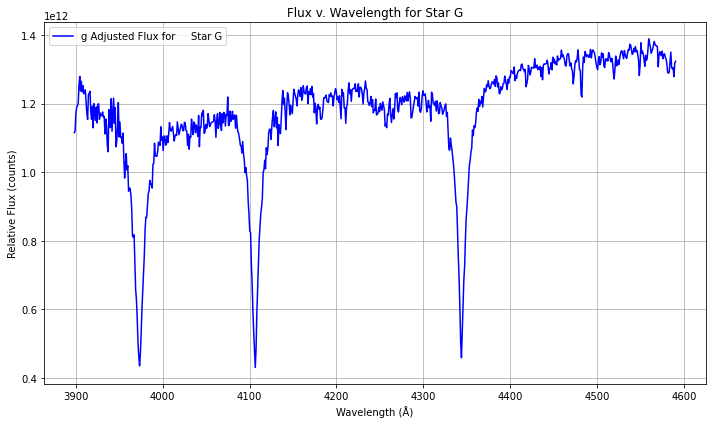

In [47]:
gg = plot_flux_vs_wavelength_G = \
plot_flux_vs_wavelength(new_x, Gstar_cal, g, 'Star G')

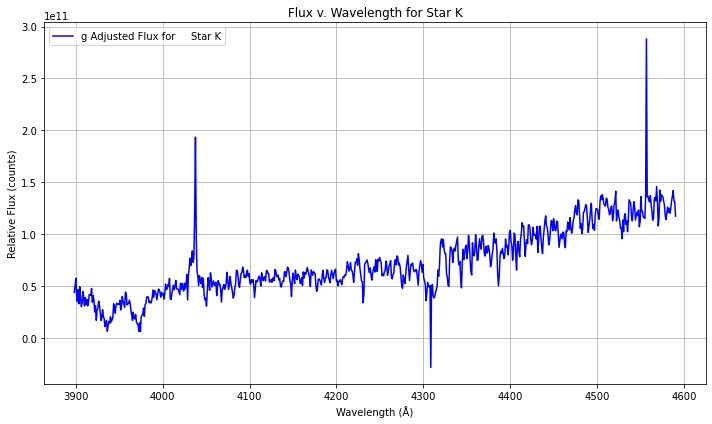

In [48]:
k = plot_flux_vs_wavelength_K = \
plot_flux_vs_wavelength(new_x, Kstar_cal, g, 'Star K')

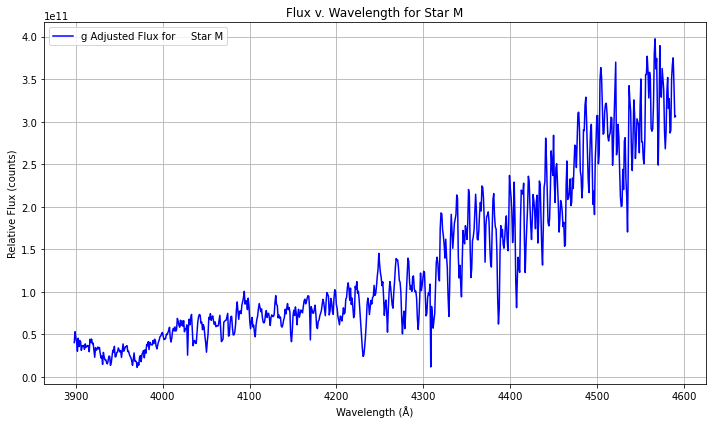

In [49]:
m = plot_flux_vs_wavelength_M = \
plot_flux_vs_wavelength(new_x, Mstar_cal, g, 'Star M')

#### Our final task is to place each of the previosuly plotted, flux and wavelenght calibrated plots onto the same plot to compare the shape of the different temperature spectra. 

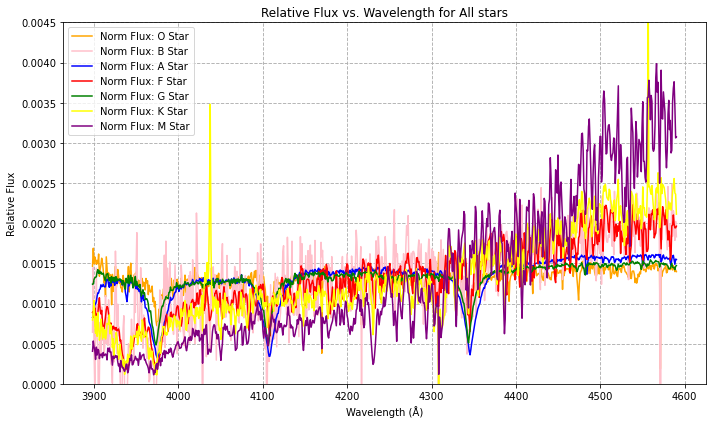

In [50]:
# Calculate the flux for each star
fluxO = Ostar_cal * g
fluxB = Bstar_cal * g
fluxA = Astar_cal * g
fluxF = Fstar_cal * g
fluxG = Gstar_cal * g
fluxK = Kstar_cal * g
fluxM = Mstar_cal * g

# Normalize the flux values to re-scale the y-axis so that the individual 
# stellar spectra can be displayed in order to compare the shape of the 
# temerature spectra.
fluxO_final = (Ostar_cal * g) / np.sum(Ostar_cal * g) 
fluxB_final = (Bstar_cal * g) / np.sum(Bstar_cal * g) 
fluxA_final = (Astar_cal * g) / np.sum(Astar_cal * g) 
fluxF_final = (Fstar_cal * g) / np.sum(Fstar_cal * g) 
fluxG_final = (Gstar_cal * g) / np.sum(Gstar_cal * g) 
fluxK_final = (Kstar_cal * g) / np.sum(Kstar_cal * g) 
fluxM_final = (Mstar_cal * g) / np.sum(Mstar_cal * g) 

# Plot the normalized spectra on the same plot as a function
# of calibrated wavelength.
plt.figure(figsize=(10, 6))
plt.plot(new_x, fluxO_final, label=f'Norm Flux: O Star', color='orange')
plt.plot(new_x, fluxB_final, label=f'Norm Flux: B Star', color='pink')
plt.plot(new_x, fluxA_final, label=f'Norm Flux: A Star', color='blue')
plt.plot(new_x, fluxF_final, label=f'Norm Flux: F Star', color='red')
plt.plot(new_x, fluxG_final, label=f'Norm Flux: G Star', color='green')
plt.plot(new_x, fluxK_final, label=f'Norm Flux: K Star', color='yellow')
plt.plot(new_x, fluxM_final, label=f'Norm Flux: M Star', color='purple')

plt.title(f'Relative Flux vs. Wavelength for All stars')
plt.xlabel('Wavelength (Å)') 
plt.ylabel('Relative Flux')
#plt.yscale('linear')
plt.ylim([0, 0.0045])
plt.grid(True, which='both', linestyle='--', linewidth=0.9)
plt.legend()
plt.tight_layout()
plt.show()